In [1]:
!pip -q install mrjob pandas matplotlib

In [2]:
import pandas as pd

In [3]:
%%file longestphrase.py
from mrjob.job import MRJob, MRStep

class MRLongestPhrase(MRJob):

    def mapper(self, _, line):
        words = (line.lower()) \
            .replace("(", '').replace(")", '').replace("!", '') \
            .replace(".", '').replace(",", '').replace("'", '') \
            .replace("?", '').replace('"', '').split()[1:]

        person = words[0]
        phrase = ' '.join(words[1:])

        yield person, (len(phrase), phrase)

    def reducer(self, person, lengths_and_phrases):
        max_length, max_phrase = max(lengths_and_phrases, key=lambda x: x[0])

        yield None, (person, max_length, max_phrase)

    def reducer_sort(self, _, person_length_phrase):
        sorted_results = sorted(person_length_phrase, key=lambda x: x[1], reverse=True)

        for person, length, phrase in sorted_results:
            yield person, (length, phrase)

    def steps(self):
        return [
            MRStep(mapper=self.mapper, reducer=self.reducer),
            MRStep(reducer=self.reducer_sort)
        ]

if __name__ == '__main__':
    MRLongestPhrase.run()

Overwriting longestphrase.py


In [4]:
!python3 longestphrase.py SW_EpisodeIV.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/longestphrase.root.20231129.131404.797093
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/longestphrase.root.20231129.131404.797093/output
Streaming final output from /tmp/longestphrase.root.20231129.131404.797093/output...
"leia"	[574, "general kenobi years ago you served my father in the clone wars now he begs you to help him in his struggle against the empire i regret that i am unable to present my fathers request to you in person but my ship has fallen under attack and im afraid my mission to bring you to alderaan has failed i have placed information vital to the survival of the rebellion into the memory systems of this r2 unit my father will know how to retrieve it you must see this droid safely delivered to him on alderaan this is our most desperate hour help me obi-wan kenobi youre my only hope"]
"dodonna"	[340, "the approach will not be ea

In [5]:
!python3 longestphrase.py SW_EpisodeIV.txt > out21.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/longestphrase.root.20231129.131405.231062
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/longestphrase.root.20231129.131405.231062/output
Streaming final output from /tmp/longestphrase.root.20231129.131405.231062/output...
Removing temp directory /tmp/longestphrase.root.20231129.131405.231062...


In [6]:
!python3 longestphrase.py SW_EpisodeV.txt > out22.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/longestphrase.root.20231129.131405.654237
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/longestphrase.root.20231129.131405.654237/output
Streaming final output from /tmp/longestphrase.root.20231129.131405.654237/output...
Removing temp directory /tmp/longestphrase.root.20231129.131405.654237...


In [7]:
!python3 longestphrase.py SW_EpisodeVI.txt > out23.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/longestphrase.root.20231129.131406.070977
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/longestphrase.root.20231129.131406.070977/output
Streaming final output from /tmp/longestphrase.root.20231129.131406.070977/output...
Removing temp directory /tmp/longestphrase.root.20231129.131406.070977...


Теперь с помощью Пандаса найдем самые длинные фразы во всех трех файлах

In [8]:
df1 = pd.read_csv('out21.csv', sep='\t', names=['name', 'phrase'], index_col=['name'])
df2 = pd.read_csv('out22.csv', sep='\t', names=['name', 'phrase'], index_col=['name'])
df3 = pd.read_csv('out23.csv', sep='\t', names=['name', 'phrase'], index_col=['name'])

Выделим в отдельную колонку максимальную длину фразы для каждого персонажа

In [9]:
import ast

df1['max_len'] = df1['phrase'].apply(lambda x: ast.literal_eval(x)[0])
df2['max_len'] = df2['phrase'].apply(lambda x: ast.literal_eval(x)[0])
df3['max_len'] = df3['phrase'].apply(lambda x: ast.literal_eval(x)[0])

Строим график для каждого эпизода

<Axes: xlabel='name'>

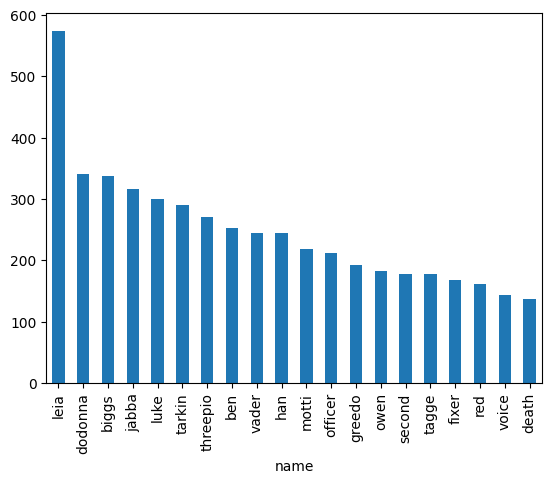

In [10]:
df1['max_len'].sort_values(ascending=False)[:20].plot(kind='bar')

<Axes: xlabel='name'>

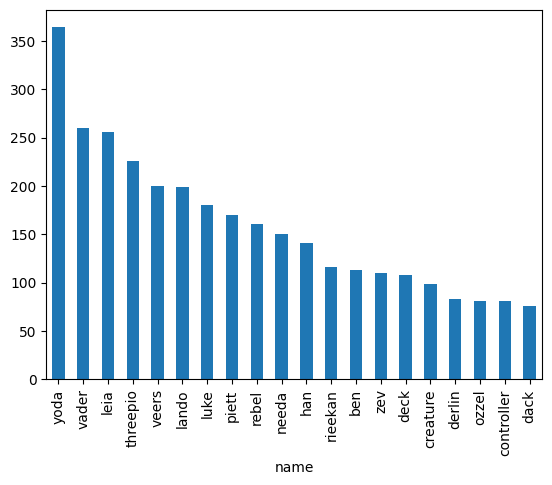

In [11]:
df2['max_len'].sort_values(ascending=False)[:20].plot(kind='bar')

<Axes: xlabel='name'>

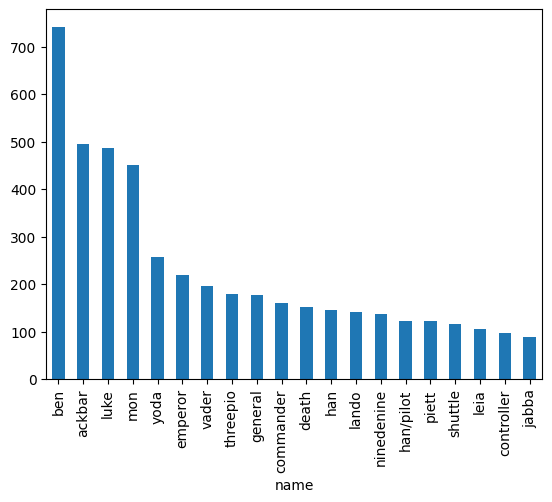

In [12]:
df3['max_len'].sort_values(ascending=False)[:20].plot(kind='bar')

Построим общий график

<Axes: xlabel='name'>

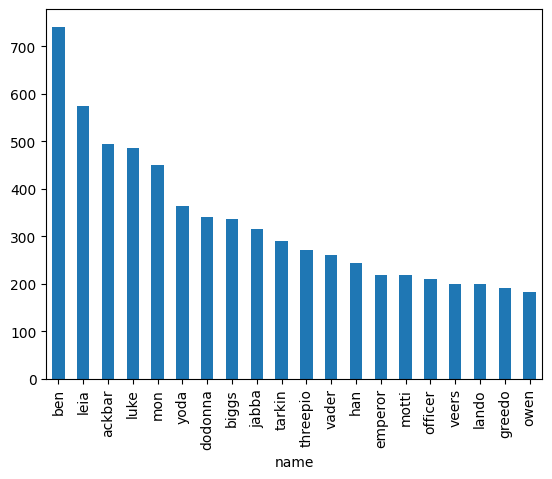

In [13]:
concatenated_df = pd.concat([df1, df2, df3])
result_df = concatenated_df.groupby(concatenated_df.index)['max_len'].max()
result_df.sort_values(ascending=False)[:20].plot(kind='bar')

Как видно самый говорящий это Бен.

In [14]:
max_phrase = ast.literal_eval(concatenated_df.iloc[concatenated_df['max_len'].argmax()]['phrase'])[1]
print(max_phrase)

the organa household was high-born and politically quite powerful in that system leia became a princess by virtue of lineage no one knew shed been adopted of course but it was a title without real power since alderaan had long been a democracy even so the family continued to be politically powerful and leia following in her foster fathers path became a senator as well thats not all she became of course she became the leader of her cell in the alliance against the corrupt empire and because she had diplomatic immunity she was a vital link for getting information to the rebel cause thats what she was doing when her path crossed yours for her foster parents had always told her to contact me on tatooine if her troubles became desperate


Запускаем на кластере

In [15]:
!python3 longestphrase.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeIV.txt --conf-path config.conf --output /hw1/output21

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/longestphrase.root.20231129.131407.645104
uploading working dir files to hdfs:///user/root/tmp/mrjob/longestphrase.root.20231129.131407.645104/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/longestphrase.root.20231129.131407.645104/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar3704363163060479477/] [] /tmp/streamjob6979574843176993232.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0037
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job:

In [16]:
!hadoop fs -cat /hw1/output21/part-00000

"leia"	[574, "general kenobi years ago you served my father in the clone wars now he begs you to help him in his struggle against the empire i regret that i am unable to present my fathers request to you in person but my ship has fallen under attack and im afraid my mission to bring you to alderaan has failed i have placed information vital to the survival of the rebellion into the memory systems of this r2 unit my father will know how to retrieve it you must see this droid safely delivered to him on alderaan this is our most desperate hour help me obi-wan kenobi youre my only hope"]
"dodonna"	[340, "the approach will not be easy you are required to maneuver straight down this trench and skim the surface to this point the target area is only two meters wide its a small thermal exhaust port right below the main port the shaft leads directly to the reactor system a precise hit will start a chain reaction which should destroy the station"]
"biggs"	[337, "i feel for you luke youre going to

In [17]:
!python3 longestphrase.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeV.txt --conf-path config.conf --output /hw1/output22

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/longestphrase.root.20231129.131550.367440
uploading working dir files to hdfs:///user/root/tmp/mrjob/longestphrase.root.20231129.131550.367440/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/longestphrase.root.20231129.131550.367440/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar4436480530430215322/] [] /tmp/streamjob6162622744837216299.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0039
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job:

In [18]:
!hadoop fs -cat /hw1/output22/part-00000

"yoda"	[364, "ready are you what know you of ready for eight hundred years have i trained jedi my own counsel will i keep on who is to be trained a jedi must have the deepest commitment the most serious mind this one a long time have i watched never his mind on where he was hmm what he was doing hmph adventure heh excitement heh a jedi craves not these things you are reckless"]
"vader"	[260, "there is no escape dont make me destroy you you do not yet realize your importance you have only begun to discover you power join me and i will complete your training with our combined strength we can end this destructive conflict and bring order to the galaxy"]
"leia"	[256, "all troop carriers will assemble at the north entrance the heavy transport ships will leave as soon as theyre loaded only two fighter escorts per ship the energy shield can only be opened for a short time so youll have to stay very close to your transports"]
"threepio"	[226, "dont try to blame me i didnt ask you to turn on th

In [19]:
!python3 longestphrase.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeVI.txt --conf-path config.conf --output /hw1/output23

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/longestphrase.root.20231129.131728.169983
uploading working dir files to hdfs:///user/root/tmp/mrjob/longestphrase.root.20231129.131728.169983/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/longestphrase.root.20231129.131728.169983/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar2287453862935499038/] [] /tmp/streamjob5956526566212424160.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0041
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job:

In [20]:
!hadoop fs -cat /hw1/output23/part-00000

"ben"	[741, "the organa household was high-born and politically quite powerful in that system leia became a princess by virtue of lineage no one knew shed been adopted of course but it was a title without real power since alderaan had long been a democracy even so the family continued to be politically powerful and leia following in her foster fathers path became a senator as well thats not all she became of course she became the leader of her cell in the alliance against the corrupt empire and because she had diplomatic immunity she was a vital link for getting information to the rebel cause thats what she was doing when her path crossed yours for her foster parents had always told her to contact me on tatooine if her troubles became desperate"]
"ackbar"	[494, "you can see here the death star orbiting the forest moon of endor although the weapon systems on this death star are not yet operational the death star does have a strong defense mechanism it is protected by an energy shield wh